## Importing the packages

In [1]:
import os 
from dotenv import load_dotenv
load_dotenv()

from langgraph.graph import StateGraph , START , END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage , AIMessage , SystemMessage
from typing import TypedDict , Annotated
from pydantic import BaseModel , Field

In [25]:
from IPython.display import Image, display
# to display the graph
def display_graph(app):
    # this function will display the graph of the app
    try:
        display(Image(app.get_graph().draw_mermaid_png()))
    except Exception as e:
        # This requires some extra dependencies and is optional
        print(e)



# To stream the output of the app
def stream_output(app, input):
    for output in app.stream(input):
        for key,value in output.items():
            print(f"here is output from {key}")
            print("_______")
            print(value)
            print("\n")

In [2]:
model = ChatOpenAI(model="gpt-4.1-mini", temperature=0)

## Part 1: Understanding pydantic validations

In [3]:
class Country(BaseModel):

    """Information about a country"""

    name: str = Field(description="name of the country")
    animal: str = Field(description="National animal of the country")
    capital: str = Field(description="Capital of the country")
    language : str = Field(description="Language of the country")
 
structured_llm = model.with_structured_output(Country)

In [4]:
structured_llm.invoke("what is the capital of india and animal of india")

Country(name='India', animal='Bengal Tiger', capital='New Delhi', language='Hindi')

In [5]:
response = structured_llm.invoke("what is the capital of india and langugae of india")
print(response)

name='India' animal='Bengal Tiger' capital='New Delhi' language='Hindi and English'


## Part 2 : Validation using TypedDict

In [6]:
from typing_extensions import Annotated, TypedDict
from typing import Optional

# TypedDict
class Joke(TypedDict):
    """Joke to tell user."""

    setup: Annotated[str, ..., "The setup of the joke"]
    punchline: Annotated[str, ..., "The punchline of the joke"]
    rating: Annotated[Optional[int], None, "How funny the joke is, from 1 to 10"]


structured_llm = model.with_structured_output(Joke)
structured_llm.invoke("Tell me a joke about cats")

{'setup': "Why don't cats play poker in the jungle?",
 'punchline': 'Too many cheetahs!',
 'rating': 7}

In [7]:
response = structured_llm.invoke("Tell me a joke about cats")

In [9]:
response

{'setup': "Why don't cats play poker in the jungle?",
 'punchline': 'Too many cheetahs!',
 'rating': 7}

In [10]:
type(response["rating"])

int

## sample code

In [11]:
class State(TypedDict):
    messages :Annotated[list , add_messages]

In [12]:
def response_from_llm(state:State):
    response = model.invoke(state["messages"])
    return {"messages" : [response]}


In [13]:
workflow = StateGraph(State)

workflow.add_node("llm" , response_from_llm)

workflow.add_edge(START , "llm")
workflow.add_edge("llm" , END)

app = workflow.compile()

In [14]:

app.invoke({"messages" : "what is langgraph?"})

{'messages': [HumanMessage(content='what is langgraph?', additional_kwargs={}, response_metadata={}, id='3b31ec0a-1330-4f5b-b56c-50a23aaf900b'),
  AIMessage(content='LangGraph is a framework or tool designed to facilitate the creation, visualization, and management of language models and natural language processing (NLP) workflows using graph-based structures. It typically allows users to represent various components of language models—such as tokens, embeddings, layers, and operations—as nodes and edges in a graph, making it easier to understand, debug, and optimize complex NLP pipelines.\n\nDepending on the specific implementation or context, LangGraph might offer features such as:\n\n- **Graph-based model construction:** Building language models by connecting modular components visually or programmatically.\n- **Visualization:** Displaying the flow of data and transformations within a language model.\n- **Interoperability:** Integrating with popular NLP libraries and frameworks.\n- 

## Part 3: using Pydantic validations in langgraph

In [15]:
#define the state
class GraphState(TypedDict):
    messages : Annotated[list, add_messages]
    code_content : Annotated[str, None]
    quality_score : Annotated[int, None]
    num_words : Annotated[int, None]

In [ ]:
model = ChatOpenAI(model="gpt-5.1-mini", temperature=0)

In [17]:
#defining class
class GenerateCode(BaseModel):
    """ 
    Extract the generated code and the num of words in the code
    """
    code : str = Field(description="Generated software code")
    num_words : int = Field(description="Number of words in the generated code")

developer_structured_llm = model.with_structured_output(GenerateCode)

In [18]:
class EvaluateCode(BaseModel):
    """
    Evaluate the generated code and return the quality score and comments
    """
    comments : str = Field(description="Comments on the code and the reason for the quality score")
    quality_score : int = Field(description="Quality score of the generated code between 0 and 100")

evaluator_structured_llm = model.with_structured_output(EvaluateCode)

In [19]:
# Nodes definition

#set the initial state
def init(state):
    print("----------- Init node ------------")
    print("State: ", state)
    return {
        "messages": [] , 
        "quality_score": 0 , 
        "num_words": 0,
        "code_content": ""
    }

In [20]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
developer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a software developer. You are given a task to generate a software code.
You will be given a task and you will need to generate a software code for the task.
Respond in json format with the following keys:
code: The generated software code
num_words: The number of words in the generated code""",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
#creating chain
developer_chain = developer_prompt | developer_structured_llm

#create a developer node 
def generate_code(state):
    developer_output = developer_chain.invoke({"messages": state["messages"]})
    print("Code generated by developer: ", developer_output.code)
    return {
        "messages": [AIMessage(content=developer_output.code)] , 
        "num_words": developer_output.num_words,
        "code_content": developer_output.code
    }

In [21]:
evaluator_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a high standard code reviewer. You will be given a code and you will need to evaluate the code and return the quality score and comments.
The quality score should be between 0 and 100.
Assess the structure , code quality and documentation of the code.
Respond in json format with the following keys:
comments: Comments on the quality score
quality_score: Quality score of the generated code between 0 and 100
            """,
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
evaluator_chain = evaluator_prompt | evaluator_structured_llm

#create a evaluator node 
def evaluate_code(state):
    evaluator_output = evaluator_chain.invoke({"messages": state["messages"]})
    print("Code evaluated by evaluator: ", evaluator_output.comments)
    return {
        "comments": evaluator_output.comments , 
        "quality_score": evaluator_output.quality_score
    }

In [22]:
def summary(state):
    print("----------- Summary node ------------")
    print("Summary: ", state)
    return state

In [23]:
workflow = StateGraph(GraphState)
workflow.add_node("init" , init)
workflow.add_node("generate_code" , generate_code)
workflow.add_node("evaluate_code" , evaluate_code)
workflow.add_node("summary" , summary)
workflow.add_edge(START , "init")
workflow.add_edge("init" , "generate_code")
workflow.add_edge("generate_code" , "evaluate_code")
workflow.add_edge("evaluate_code" , "summary")
workflow.add_edge("summary" , END)
app = workflow.compile()

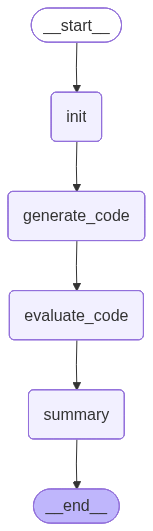

In [26]:
display_graph(app)

In [27]:
if __name__ == "__main__":

    import json
    import os

    output_dir = "part3_pydantic_validations"
    os.makedirs(output_dir, exist_ok=True)

    while True:
        user_input = input("Enter your coding task: ")
        if user_input.lower() == "exit":
            break
        result = app.invoke({"messages": [HumanMessage(content=user_input)]})
        print("**************************")
        print(json.dumps(result, default=str, indent=2))
        # Dump the result as JSON in the part3_pydantic_validations folder
        output_path = os.path.join(output_dir, "result.json")
        with open(output_path, "w") as f:
            json.dump(result, f, default=str, indent=2)
        print(f"Result dumped to {output_path}")

----------- Init node ------------
State:  {'messages': [HumanMessage(content='write a merge sort function and validate it with examples', additional_kwargs={}, response_metadata={}, id='fcc71da9-6917-4510-b26e-6678c7508e09')]}
Code generated by developer:  def merge_sort(arr):
    if len(arr) <= 1:
        return arr
    mid = len(arr) // 2
    left = merge_sort(arr[:mid])
    right = merge_sort(arr[mid:])

    sorted_arr = []
    i = j = 0
    while i < len(left) and j < len(right):
        if left[i] < right[j]:
            sorted_arr.append(left[i])
            i += 1
        else:
            sorted_arr.append(right[j])
            j += 1
    sorted_arr.extend(left[i:])
    sorted_arr.extend(right[j:])
    return sorted_arr

# Validation examples
print(merge_sort([38, 27, 43, 3, 9, 82, 10]))  # [3, 9, 10, 27, 38, 43, 82]
print(merge_sort([5, 2, 4, 6, 1, 3]))           # [1, 2, 3, 4, 5, 6]
print(merge_sort([]))                            # []
print(merge_sort([1]))                 